# Processamento de Linguagem Natural - Trabalho Prático 1

Nome: Marco Antonio Rocha Vinha
Data: 12/12/2024

Link para o repositório no GitHub: https://github.com/marcoVinha/nlp-tp1

In [1]:
import logging
import sys


date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.WARNING, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

# Objetivo do trabalho

O objetivo deste trabalho é explorar o conceito de “representações distribuídas, densas, altamente informativas, através de fatores latentes” ("word embeddings"). Cinquenta e quatro modelos Word2Vec vão ser treinados na busca daquele que melhor representa palavras em um espaço N-dimensional.

# Dados



### Dados de treinamento

Os dados utilizados no treinamento dos modelos podem ser encontrados em:
- http://mattmahoney.net/dc/text8.zip

### Dados de analogias

Os dados de analogias utilizados na avaliação da performance dos modelos podem ser encontrados em:
- https://raw.githubusercontent.com/nicholas-leonard/word2vec/refs/heads/master/questions-words.txt

# Definindo o modelo

O código que define a arquitetura do modelo é definido dentro do pacote Python `gensim`. Cada modelo avaliado será treinado com um conjunto específico de valores para os hiper-parâmetros:

- Tipo de modelo: CBOW ou Skipgram
- Tamanho da janela de contexto
- Tamanho do embedding que representará as palavras
- Quantidade de épocas utilizadas no treinamento

Os valores para cada hiper-parâmetro serão definidos em uma rotina de Grid Search, de implementação própria.

## Wrapper para a API do `gensim`

A API do pacote Python `gensim` define a classe `Word2Vec`, que pode ser utilizada para criar modelos CBOW ou Skipgram - uma definição passada como parâmetro de instância da classe. Os outros parâmetros de interesse para este trabalho podem ser passados, tanto na instância da classe, quanto como parâmetros para o método `Word2Vec.train`.

Para a execução do trabalho, foram tomadas algumas decisões:

- A criação de uma classe `StoreLossCurveCallback`, usada como "callback" durante o treinamento dos modelos, e que tem o objetivo de armazenar e exibir o valor da função de perda de cada modelo ao fim de cada época do treinamento.
- A criação de um "wrapper" para a classe original do pacote `gensim`, `Word2VecModel`, que abstrai as rotinas de instância e de treinamento do modelo em uma interface mais "amigável", que cria e chama explicitamente o método de treinamento de cada modelo instanciado.


In [2]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from typing import Iterable

In [3]:
class StoreLossCurveCallback(CallbackAny2Vec):
    """
    Classe usada como "callback" durante o treinamento 
    dos modelos Word2Vec. Exibe o valor da função de perda
    ao final de cada época do treinamento
    """

    def __init__(self):
        self.epoch = 0
        self.last_logged_loss = 0
        self.loss_curve = []

    def on_epoch_end(self, model):
        """
        O método `on_epoch_end` é executado ao fim de cada
        época do treinamento do modelo.
        """

        curr_loss = model.get_latest_training_loss() - self.last_logged_loss
        self.last_logged_loss = model.get_latest_training_loss()

        self.loss_curve.append(curr_loss)

        print(
            f"Loss for epoch #{self.epoch}: {curr_loss}"
        )

        self.epoch += 1

In [4]:
class Word2VecModel:
    """
    Wrapper para a classe `gensim.models.Word2Vec`, criado
    com o intuito de separar a instância e o treinamento
    do modelo.

    Args:
        model_type: tipo do modelo (`cbow` ou `skipgram`).
        window_size: tamanho da janela de contexto do modelo.
        embedding_size: número de dimensões utilizadas para
            representar cada palavra no corpus de treinamento.
        workers: número de threads criadas para o treinamento
            do modelo.
    """

    def __init__(
        self,
        model_type: str,
        window_size: int,
        embedding_size: int,
        workers: int = 8,
    ):
        self.model_type = model_type
        self._sg = 1 if model_type ==  "skipgram" else 0
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.min_word_count = 0
        self.workers = workers
        self.compute_loss = True

        self._loss_container = StoreLossCurveCallback()
        self.loss_curve = []

        self.model =  Word2Vec(
            sg=self._sg,
            window=self.window_size,
            vector_size=self.embedding_size,
            min_count=self.min_word_count,
            workers=self.workers,
        )


    @property
    def wv(self):
        return self.model.wv


    def _build_vocab(self, dataset):
        self.model.build_vocab(dataset)


    def train(
        self,
        dataset: Iterable,
        epochs: int,
    ):
        """
        Função que executa o treinamento do modelo.

        Args:
            dataset: iterável sobre o corpus de treinamento.
            epochs: número de épocas executadas no treinamento.
        """
    
        self._build_vocab(dataset)

        self.model.train(
            corpus_iterable=dataset,
            epochs=epochs,
            total_words=self.model.corpus_total_words,
            compute_loss=self.compute_loss,
            callbacks=[self._loss_container],
        )

        self.loss_curve = self._loss_container.loss_curve


## Buscando a melhor configuração de hiper-parâmetros

### Preparando dados de teste

É esperado que os dados de teste estejam em um arquivo `data/analogies.txt` - (download pode ser feito pelo arquivo `shellscripts/download-analogies-data.sh`).
O arquivo será pré-processado de maneira em que cada sub-categoria de analogias seja a chave de um dicionário cujos valores sejam as listas com cada analogia dentro daquela sub-categoria. Exemplo:

    {
        "sub_categoria_1": [
            ["palavra_1", "palavra_2", "palavra_3", "palavra_4"]
        ]
    }

A operação de cálculo das analogias pode ser representada pela expressão:

$$w_1 - w_2 + w_4 = \hat{w}_3$$

Na expressão, $w_1$, $w_2$ e $w_4$ são as representações densas da primeira, da segunda e da quarta palavras em cada linha do arquivo de analogias, e $\hat{w}_3$ é o resultado da operação algébrica descrita pela mesma expressão. O melhor modelo encontrado, será aquele que maximiza o valor da similaridade de cosseno, dado pela expressão abaixo. Nela, $w_3$ é o vetor associado à terceira palavra em cada linha do arquivo de analogias.

$$similaridade\ de\ cosseno = \frac{\hat{w}_3 \cdot w_3}{|\hat{w}_3| \times |w_3|}$$

No código, a função `evaluate_analogy` executa esse cálculo e, ao fim de cada treinamento, a função `build_report` constrói um relatório indicando, para cada um dos 54 modelos, cada conjunto de hiper-parâmetros usado para treinar o modelo e qual o valor de média de similaridade de cosseno encontrada com aquele modelo.



In [5]:
analogies_file_name = "../data/analogies.txt"

with open(analogies_file_name) as file:
    file_content = file.read().splitlines()

all_test_analogies = {}
last_key_added = None
for line in file_content:
    if line[0] == ":":
        last_key_added = line.replace(": ", "")
        all_test_analogies[last_key_added] = []

    else:
        all_test_analogies[last_key_added].append(
            line.lower().split(" ")
        )

In [6]:
import numpy as np

def evaluate_analogy(model, analogy):
    def cosine_similarity(a, b):
        return (
            np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        )

    w1_embedding = model.wv[analogy[0]]
    w2_embedding = model.wv[analogy[1]]
    w3_embedding = model.wv[analogy[2]]
    w4_embedding = model.wv[analogy[3]]

    return cosine_similarity(
        w1_embedding - w2_embedding + w4_embedding,
        w3_embedding,
    )

In [7]:
def build_report(model, test_analogies):
    total_ignored_analogies = 0

    report = {}
    for sub_category in test_analogies.keys():
        similarities = []
        for curr_sample in test_analogies[sub_category]:
            if all([model.wv.__contains__(sample) for sample in curr_sample]):
                curr_similarity = evaluate_analogy(model, curr_sample)
                similarities.append(curr_similarity)

            else:
                total_ignored_analogies += 1

        report[sub_category] = np.average(similarities)

    if total_ignored_analogies:
        print(
            f"[WARNING] A total of {total_ignored_analogies} samples were ignored because they contained "
            "words out of the model's vocabulary."
        )

    report["overall_average"] = np.average(list(report.values()))

    return report

### Rotina de Grid Search

A rotina de Grid Search implementada testa um total de 54 configurações de hiper-parâmetros.
- Para o tipo de arquitetura utilizada, existem dois valores possíveis: CBOW ou Skipgram
- Para o número de dimensões usadas para representar cada palavra, existem três valores possíveis: 5, 25 ou 100
- Para o tamanho da janela de contexto, são três valores: 3, 7 ou 15
- Para o número de épocas, existem três valores possíveis: 2, 5 ou 10


In [8]:
from itertools import product
import gensim.downloader as gensim_downloader
from gensim.test.utils import datapath

In [9]:
train_dataset = gensim_downloader.load("text8")

In [10]:
def run_grid_search(
    train_dataset,
    param_grid: dict,
    test_analogies: dict,
    return_best: bool = False
):
    param_combinations = list(product(*param_grid.values()))

    param_keys = list(param_grid.keys())

    curr_train = 0

    results = []
    for params in param_combinations:
        param_dict = dict(zip(param_keys, params))

        model = Word2VecModel(
            model_type=param_dict["model_type"],
            window_size=param_dict["window_size"],
            embedding_size=param_dict["embedding_size"],
            workers=12,
        )

        print(
            f"Starting training model {curr_train}. Will train for {param_dict['epochs']} epochs."
        )
        print(
            f"model_type: {model.model_type}, window_size: {model.window_size}, embedding_size: {model.embedding_size}"
        )

        model.train(
            dataset=train_dataset,
            epochs=param_dict["epochs"],
        )

        curr_model_report = build_report(model, test_analogies)
        score = curr_model_report["overall_average"]

        print(f"Final analogies score: {score}\n")

        results.append(
            {"params": param_dict, "score": score, "full_report": curr_model_report}
        )

        curr_train += 1

    if not return_best:
        return results

    return max(results, key=lambda x: x["score"])

In [11]:
%%time

param_grid = {
    "model_type": ["skipgram", "cbow"],
    "embedding_size": [5, 25, 100],
    "window_size": [3, 7, 15],
    "epochs": [2, 5, 10],
}

grid_search_results = run_grid_search(
    train_dataset=train_dataset,
    param_grid=param_grid,
    test_analogies=all_test_analogies,
    return_best=False
)

Starting training model 0. Will train for 2 epochs.
model_type: skipgram, window_size: 3, embedding_size: 5
Loss for epoch #0: 15028768.0
Loss for epoch #1: 11636486.0
[WARNING] A total of 438 samples were ignored because they contained words out of the model's vocabulary.
Final analogies score: 0.9138568639755249

Starting training model 1. Will train for 5 epochs.
model_type: skipgram, window_size: 3, embedding_size: 5
Loss for epoch #0: 15037490.0
Loss for epoch #1: 10933544.0
Loss for epoch #2: 9493698.0
Loss for epoch #3: 6073528.0
Loss for epoch #4: 5968924.0
[WARNING] A total of 438 samples were ignored because they contained words out of the model's vocabulary.
Final analogies score: 0.913713276386261

Starting training model 2. Will train for 10 epochs.
model_type: skipgram, window_size: 3, embedding_size: 5
Loss for epoch #0: 14924328.0
Loss for epoch #1: 10919404.0
Loss for epoch #2: 9320512.0
Loss for epoch #3: 6044308.0
Loss for epoch #4: 5967064.0
Loss for epoch #5: 58561

### Resultados

As varíaveis `best_model_report` e `worst_model_report` guardam os relatórios obtidos para o melhor e para o pior modelos testados, respectivamente. A chave `score` em cada relatório final guarda o valor médio do cálculo da similaridade de cosseno obtida com os modelo.

- O melhor modelo teve média de similaridade de cosseno de cerca de $0.91$
- O pior modelo teve média de similaridade de cosseno de cerca de $0.43$

In [12]:
best_model_report = max(grid_search_results, key=lambda x: x["score"])

In [13]:
worst_model_report = min(grid_search_results, key=lambda x: x["score"])

In [14]:
print(
    f"Best model score: {best_model_report['score']}\nWorst model score: {worst_model_report['score']}"
)

Best model score: 0.9141297936439514
Worst model score: 0.4376334547996521


### Treinando melhor e pior modelos com os parâmetros encontrados

Uma vez encontrados o melhor e o pior modelos, eles são recriados para o restante das análises.

#### Melhor modelo

In [15]:
print(
    f"Set of hiper-parameters for the best model found: {best_model_report['params']}"
)

Set of hiper-parameters for the best model found: {'model_type': 'skipgram', 'embedding_size': 5, 'window_size': 7, 'epochs': 2}


In [16]:
best_model = Word2VecModel(
    model_type=best_model_report["params"]["model_type"],
    window_size=best_model_report["params"]["window_size"],
    embedding_size=best_model_report["params"]["embedding_size"],
    workers=12,
)

best_model.train(
    dataset=train_dataset,
    epochs=best_model_report["params"]["epochs"],
)

Loss for epoch #0: 16483415.0
Loss for epoch #1: 13070615.0


#### Pior modelo

In [17]:
print(
    f"Set of hiper-parameters for the worst model found: {worst_model_report['params']}"
)

Set of hiper-parameters for the worst model found: {'model_type': 'cbow', 'embedding_size': 100, 'window_size': 15, 'epochs': 10}


In [18]:
worst_model = Word2VecModel(
    model_type=worst_model_report["params"]["model_type"],
    window_size=worst_model_report["params"]["window_size"],
    embedding_size=worst_model_report["params"]["embedding_size"],
    workers=12,
)

worst_model.train(
    dataset=train_dataset,
    epochs=worst_model_report["params"]["epochs"],
)

Loss for epoch #0: 5276335.5
Loss for epoch #1: 4112554.5
Loss for epoch #2: 3660677.0
Loss for epoch #3: 3579316.0
Loss for epoch #4: 2941183.0
Loss for epoch #5: 2857944.0
Loss for epoch #6: 2836286.0
Loss for epoch #7: 2783282.0
Loss for epoch #8: 2745028.0
Loss for epoch #9: 2679936.0


# Avaliando embeddings gerados

Para a visualização de embeddings de modelos que usam mais de duas dimensões para representar palavras, é necessário o uso de técnicas de redução de dimensionalidade, que projetam um espaço N-dimensional em um espaço bi-dimensional. Existem algumas técnicas que fazem essa tarefa, como o [PCA](https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html), o [t-SNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html), ou o [UMAP](https://arxiv.org/abs/1802.03426). A técnica de UMAP vem ganhado popularidade como uma técnica de redução de dimensionalidade que escala melhor do que outras (como o PCA e o t-SNE) em relação à quantidade de dados e ao número de dimensões de um dataset, e isso motivou a sua escolha para este trabalho.

## Embeddings de dados aleatórios

Para fins de comparação, é interessante observar como é a visualização de embeddings de um modelo que não foi treinado. Para conseguirmos algo equivalente a isso, podemos criar uma série de vetores aleatórios com distribuição uniforme e mostrar como eles são projetados em um espaço de duas dimensões. Para fins de exemplo, serão criados $253854$ vetores de $100$ dimensões, representando vetores aleatórios de $100$ dimensões para cada uma das distintas palavras no corpus de treinamento dos 54 modelos treinados.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random
from umap.umap_ import UMAP

/home/marcovinha/nlp-tp1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reduce_dimensions_untrained_model(vectors):
    reducer = UMAP()
    reducer.fit(vectors)
    vectors = reducer.transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]

    return x_vals, y_vals


def plot_embeddings_untrained_model(x_vals, y_vals):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

In [3]:
random_embeddings = np.random.random((253854, 100))

untrained_model_x, untrained_model_y = reduce_dimensions_untrained_model(random_embeddings)

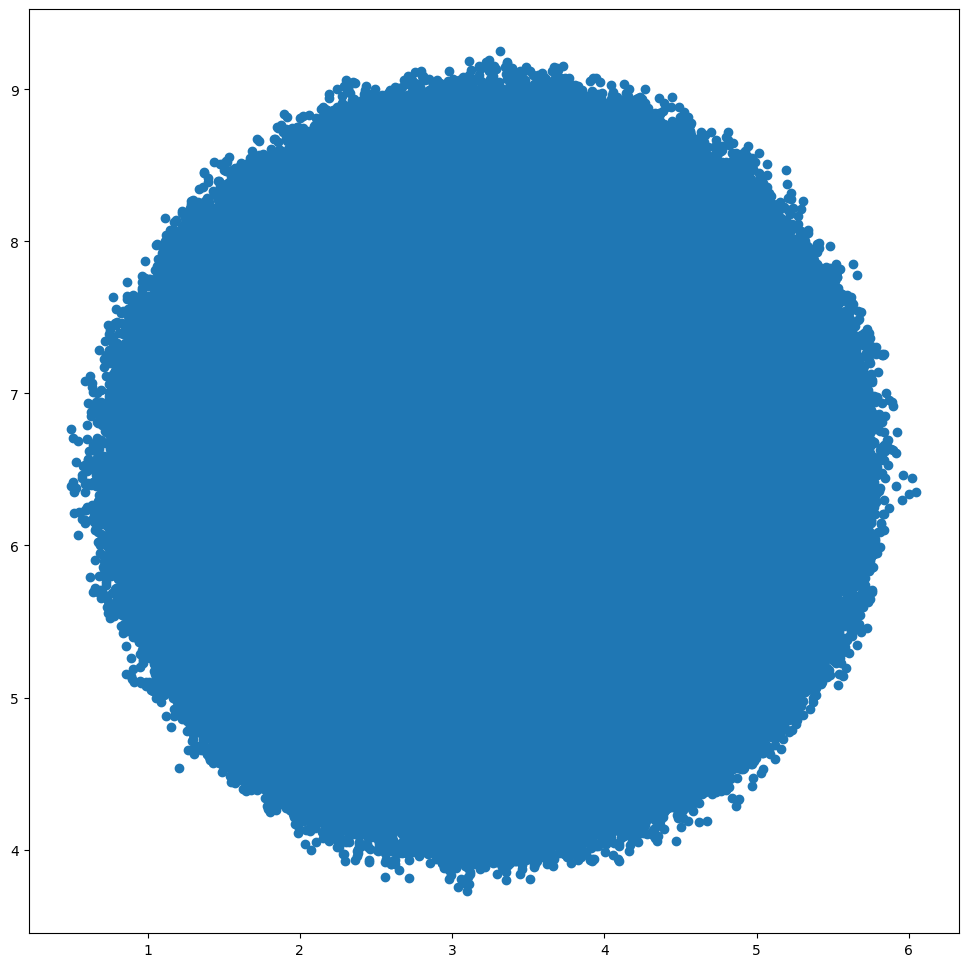

In [4]:
plot_embeddings_untrained_model(untrained_model_x, untrained_model_y)

## Embeddings das palavras nos dados de analogias

Agora, para mostrar a mesma visualização para os modelos treinados, serão selecionadas algumas sub-categorias das palavras na lista de analogias. Palavras em uma mesma sub-categoria deveriam, em tese, estar próximas na visualização.

In [19]:
analogies_words = {}
for sub_categories, words_lists in all_test_analogies.items():
    analogies_words[sub_categories] = list(set(np.array(words_lists).flatten()))

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import random

from umap.umap_ import UMAP


def reduce_dimensions(model):
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    reducer = UMAP()
    reducer.fit(vectors)
    vectors = reducer.transform(vectors)
    

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels, n_sample, indices_to_highlight=None):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    if not indices_to_highlight:
        indices = list(range(len(labels)))

    else:
        indices = indices_to_highlight

    selected_indices = random.sample(indices, min(n_sample, len(indices)))

    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

/home/marcovinha/nlp-tp1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Embeddings do melhor modelo

In [21]:
best_model_x_vals, best_model_y_vals, best_model_labels = reduce_dimensions(best_model)

### Embeddings das palavras na sub-categoria "family"

In [22]:
best_model_words_to_highlight = [
    best_model.wv.key_to_index[word] for word in analogies_words["family"] if word in best_model.wv.key_to_index
]

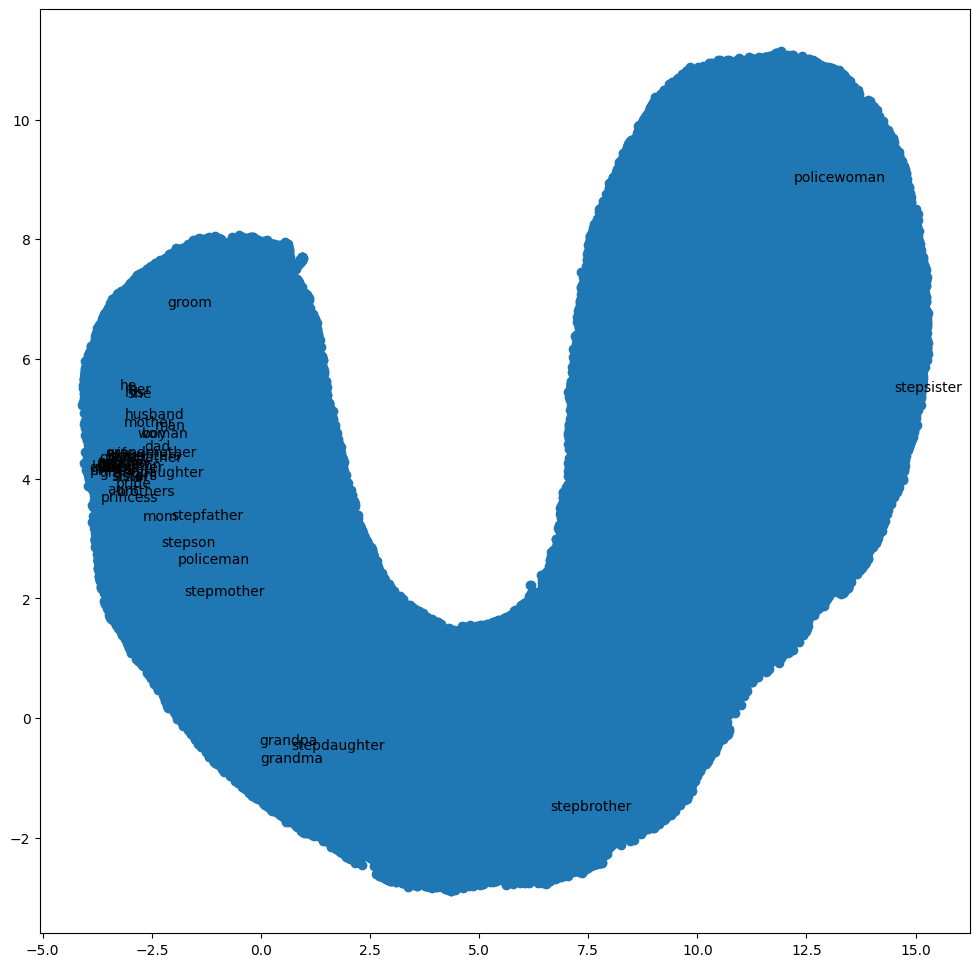

In [23]:
plot_embeddings(
    best_model_x_vals,
    best_model_y_vals,
    best_model_labels,
    n_sample=100,
    indices_to_highlight=best_model_words_to_highlight
)

### Embeddings das palavras na sub-categoria "city-in-state"

In [24]:
best_model_words_to_highlight = [
    best_model.wv.key_to_index[word] for word in analogies_words["city-in-state"] if word in best_model.wv.key_to_index
]

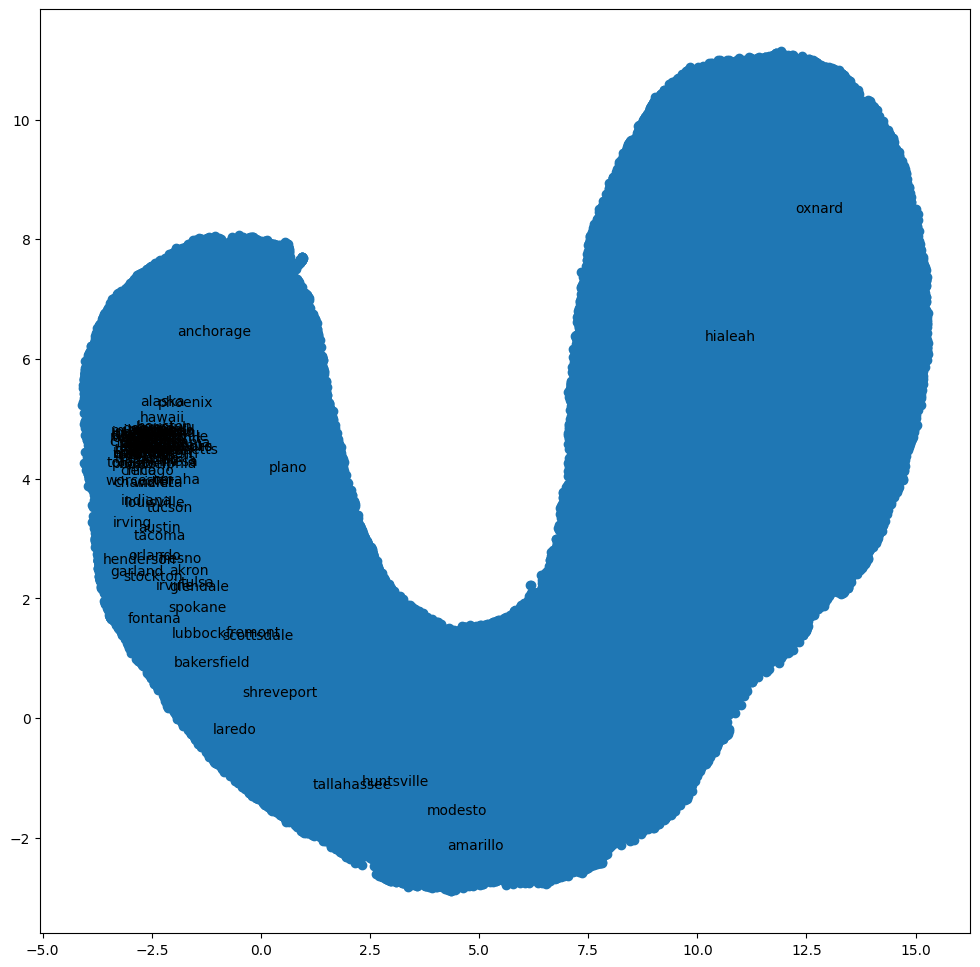

In [25]:
plot_embeddings(
    best_model_x_vals,
    best_model_y_vals,
    best_model_labels,
    n_sample=100,
    indices_to_highlight=best_model_words_to_highlight
)

## Embeddings do pior modelo

In [26]:
worst_model_x_vals, worst_model_y_vals, worst_model_labels = reduce_dimensions(worst_model)

### Embeddings das palavras na sub-categoria "family"

In [27]:
worst_model_words_to_highlight = [
    worst_model.wv.key_to_index[word] for word in analogies_words["family"] if word in worst_model.wv.key_to_index
]

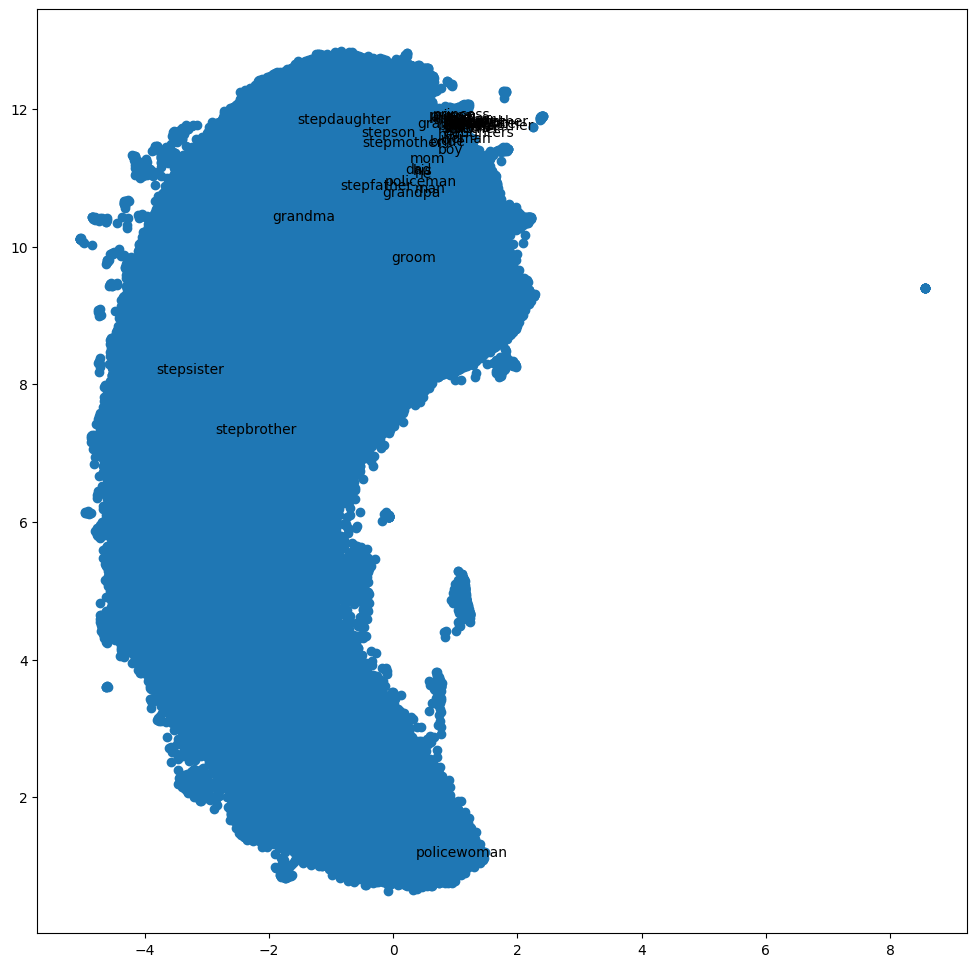

In [28]:
plot_embeddings(
    worst_model_x_vals,
    worst_model_y_vals,
    worst_model_labels,
    n_sample=100,
    indices_to_highlight=worst_model_words_to_highlight
)

### Embeddings das palavras na sub-categoria "city-in-state"

In [29]:
worst_model_words_to_highlight = [
    worst_model.wv.key_to_index[word] for word in analogies_words["city-in-state"] if word in worst_model.wv.key_to_index
]

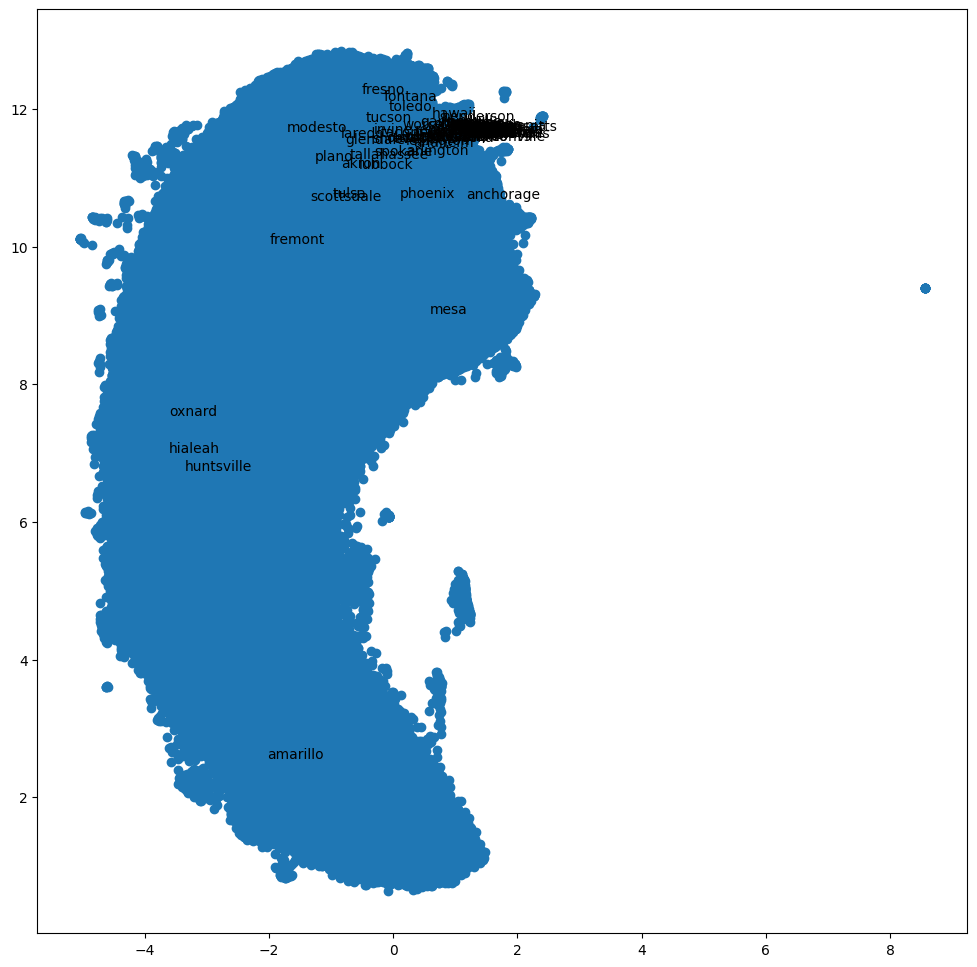

In [30]:
plot_embeddings(
    worst_model_x_vals,
    worst_model_y_vals,
    worst_model_labels,
    n_sample=100,
    indices_to_highlight=worst_model_words_to_highlight
)

# Avaliando acurácia

A API do `gensim` também fornece algumas outras maneiras de se medir a performance de um modelo. Uma dessas medidas é a acurácia dos embeddings ("top-1 accuracy"), calculada com base na distância entre os embeddings de todas as palavras no vocabulário final e o valor de $\hat{w}_3$, mostrado na expressão que define a operação de analogia. Para o cálculo do valor da acurácia, se tem um "True Positive" se a palavra algebricamente mais próxima ao valor de $\hat{w}_3$ é, de fato, a terceira palavra na lista de analogias do arquivo de testes.




## Acurácia do melhor modelo

In [31]:
best_model_accuracy, _ = best_model.model.wv.evaluate_word_analogies(datapath("questions-words.txt"))

In [32]:
print(
    f"Accuracy for the best model found: {best_model_accuracy}"
)

Accuracy for the best model found: 0.0004187166335182665


## Acurácia do pior modelo

In [33]:
worst_model_accuracy, _ = worst_model.model.wv.evaluate_word_analogies(datapath("questions-words.txt"))

In [34]:
print(
    f"Accuracy for the worst model found: {worst_model_accuracy}"
)

Accuracy for the worst model found: 0.3003768449701664


# Conclusões

## Sobre as avaliações feitas

- Na similaridade de cosseno, maiores modelos apresentam menor média de similaridade de cosseno no cálculo das analogias, enquanto menores modelos apresentam maiores médias de similaridade.
- Na acurácia, maiores modelos apresentam maior acurácia no cálculo das analogias, enquanto menores modelos apresentam menores médias de acurácia.
- Na a visualização de embeddings, mesmo selecionando sub-conjuntos de palavras a serem exibidas, reduzir drasticamente o número de dimensões prejudica a visualização. Ainda assim, comparar essas visualizações com as de um modelo hipotético não treinado parece servir como um indicativo da eficácia do processo de treinamento.

## Conclusões gerais

Parece contra-intuitivo que menores modelos sejam os melhores na média de similaridade de cosseno na avaliação das analogias. Pelos números de hiper-parâmetros obtidos, é possível imaginar que modelos que usam 2 a 5 dimensões para representar palavras as representassem de maneira muito pouco efetiva. Ao mesmo tempo, o cálculo da acurácia das analogias parece dizer que, realmente, modelos muito pequenos representam mal as palavras do corpus de treinamento.

Dado isso, é valido o questionamento: por que não executar o Grid Search usando como métrica objetivo o score de acurácia? O problema aqui está na complexidade de tempo do cálculo da acurácia. Para o cálculo da similaridade de cosseno, a complexidade de tempo é, no pior caso, de $O(n)$, com $n$ sendo o número de linhas no arquivo de analogias. Para o cálculo da acurácia, a complexidade de tempo no pior caso é de $O(n \times m)$, com $n$ sendo o número de linhas no arquivo de analogias e $m$ sendo o número de palavras distintas no corpus de treinamento.

O real motivo da divergência entre as métricas de acurácia e média de similaridade de cosseno fica, portanto, em aberto.